In [1]:
__author__ = 'Knut Olsen <knut.olsen@noirlab.edu>'
__version__ = '20240213' # yyyymmdd
__datasets__ = ['phat_v2']
__keywords__ = ['M31', 'Healpix map', 'plot:cmd', 'lightcurve']

# Fun with PHAT!

*Knut Olsen & the Astro Data Lab Team*

## Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Basic info](#basic)
* [Examine the columns of the PHAT object table](#columns)
* [Make an object density map](#density)
* [Make depth and color maps](#depth)
* [Do a spatial query and make color-color diagrams and CMDs](#cmd)
* [Retrieving time series photometry of select objects](#timeseries)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
* Learn how to access the PHAT average photometry and single epoch measurement tables
* Learn how to use an SQL query to make Healpix maps of object density, average depth, average color, and PHAT brick number
* Learn how to retrieve and plot lightcurve data from the PHAT single epoch measurement table

# Summary
The Panchromatic Hubble Andromeda Treasury (PHAT; PI Dalcanton) was a Hubble Space Telescope Multi-cycle program to map roughly a third of M31's star forming disk, using 6 filters covering from the ultraviolet through the near infrared. 

The Data Lab hosts two main tables from PHAT: the version 2 object table (phat_v2.phot_mod) and the version 2 single epoch measurement table (phat_v2.phot_meas).  The object table contains average photometry in all filters, with one row per object.  The measurement table contains all of the photometric measurements for all objects, with one row per measurement.  The measurement table contains ~7.5 billion rows.

In this notebook, we'll use these tables to do some exploration of the PHAT survey.


<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

* PHAT Reduction paper: Williams et al., "Reducing and Analyzing the PHAT Survey with the Cloud", ApJS, 2018, 236, 4: https://ui.adsabs.harvard.edu/abs/2018ApJS..236....4W

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
from getpass import getpass

%matplotlib inline

# Datalab and related imports
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
#ac.whoAmI()

<a class="anchor" id="basic"></a>
# Basic info
First, let's look at the tables available in the PHAT database, and then get some basic information from the Data Lab statistics database (<tt>tbl_stat</tt>) about the main PHAT object table, phat_v2.phot_mod. 

In [4]:
try:
    print(qc.schema('phat_v2',format='json',profile='default'))
except Exception as e:
    print(e.message)


Schema: phat_v2

      Table Name   Description
      ----------   -----------
       phot_meas   Individual photometric measurements, one row per measurement
        phot_mod   Combined average photometry
x1p5__phot_mod__allwise__source   phat_v2.phot_mod and allwise.source crossmatch (1.5 arcsec)
x1p5__phot_mod__gaia_dr3__gaia_source   xmatch_std.phat_v2__phot_mod and gaia_dr3.gaia_source cros
                   smatch (1.5 arcsec)
x1p5__phot_mod__unwise_dr1__object   phat_v2.phot_mod and unwise_dr1.object crossmatch (1.5 arcsec)



In [5]:
query = "SELECT * FROM tbl_stat WHERE schema='phat_v2' and tbl_name='phot_mod'" # Retrieve useful stats, quickly
try:
    info = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [6]:
print(info)

schema,tbl_name,nrows,ncols,nindex,table_size,indexes_size,total_size
phat_v2,phot_mod,108897584,92,49,46965063680,86388244480,133353308160



<a class="anchor" id="columns"></a>
# Examine the columns of the PHAT object table
First, we'll take a look at some rows from phat_v2.phot_mod, and get all columns.

In [7]:
query = """SELECT *
           FROM phat_v2.phot_mod
           LIMIT 100
        """

In [8]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

### Convert the output to a Pandas Dataframe
Pandas dataframes are a convenient way to store and work with the data.  The Data Lab 'helpers' module (<a href="http://datalab.noirlab.edu/docs/manual/UsingAstroDataLab/ClientInterfaces/Helpers/Helpers.html">docs</a>) has a conversion method, with many possible output formats.

In [9]:
df1 = convert(result,'pandas')
print("Number of rows:", len(df1))
print(df1.columns) # print column headings
print(len(df1.columns))

Number of rows: 100
Index(['ra', 'dec', 'elon', 'elat', 'glon', 'glat', 'field', 'brick', 'x', 'y',
       'f110w_rate', 'f110w_raterr', 'f110w_vega', 'f110w_err', 'f110w_chi',
       'f110w_snr', 'f110w_sharp', 'f110w_round', 'f110w_crowd', 'f160w_rate',
       'f160w_raterr', 'f160w_vega', 'f160w_err', 'f160w_chi', 'f160w_snr',
       'f160w_sharp', 'f160w_round', 'f160w_crowd', 'f275w_rate',
       'f275w_raterr', 'f275w_vega', 'f275w_err', 'f275w_chi', 'f275w_snr',
       'f275w_sharp', 'f275w_round', 'f275w_crowd', 'f336w_rate',
       'f336w_raterr', 'f336w_vega', 'f336w_err', 'f336w_chi', 'f336w_snr',
       'f336w_sharp', 'f336w_round', 'f336w_crowd', 'f475w_rate',
       'f475w_raterr', 'f475w_vega', 'f475w_err', 'f475w_chi', 'f475w_snr',
       'f475w_sharp', 'f475w_round', 'f475w_crowd', 'f814w_rate',
       'f814w_raterr', 'f814w_vega', 'f814w_err', 'f814w_chi', 'f814w_snr',
       'f814w_sharp', 'f814w_round', 'f814w_crowd', 'ir_x', 'ir_y',
       'f814w_f475w', 'f475w_f33

<a class="anchor" id="density"></a>
# Make an object density map
One of the columns in the PHAT object table, nest4096, is the Healpix index (NSIDE=4096, nested scheme) for the objects's RA and Dec.  Healpix is a handy tesselation of the sky into tiles of equal area.  The Python module healpy has all of the Healpix related functions.

To make maps of aggregate quantities in PHAT, we're going to use the database to return results in a query grouped by Healpix index value.  We can then put the results into arrays, and use healpy's functionality to display the maps.

In this first query, the GROUP BY clause tells the database to aggregate the results by the values in the nest4096 column, and return the average RA and Dec of objects in those groups, as well as the nest4096 value itself and the count of the number of objects in the group.


In [10]:
query = """SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb
           FROM phat_v2.phot_mod
           GROUP BY nest4096
        """

In [11]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

### Convert the output to a Pandas Dataframe
We'll once again use helpers to convert the result to a Pandas dataframe.  Our dataframe has one row per Healpix.  We'll check that the sum of the number of objects in all Healpixels equals the number of rows in the table.

In [12]:
df_density = convert(result,'pandas')
print("Number of rows:", len(df_density))
print(np.sum(df_density['nb'])) # print total counts

Number of rows: 2451
108897575


### Making the Healpix map
A Healpix map is simply a one-dimensional array with number of elements set by the NSIDE parameter, which is the number of times the base Healpixels are split.  We can visualize it as a map using the <tt>healpy</tt> library.

In [13]:
hmap = np.zeros(hp.nside2npix(4096))

In [14]:
print(df_density.head())

         ra0       dec0  nest4096     nb
0  10.987294  41.109718  10746303   3843
1  11.052648  41.087117  10746315    462
2  11.059957  41.092093  10746318  11578
3  11.069437  41.104929  10746319   6987
4  11.077243  41.115676  10746330   1383


### Populating the Healpix map
Now we set the elements of our Healpix map to the number of objects returned by the query, calculate the center of the RA and Dec distribution of the objects, and use healpy's gnomview to visualize the output. Notice anything funny?  The PHAT object table has duplicate objects between some of the bricks (bricks 11, 12, 13, and 14).

In [15]:
hmap[df_density['nest4096']]=df_density['nb']
(rarot,decrot)=(np.median(df_density['ra0']),np.median(df_density['dec0']))

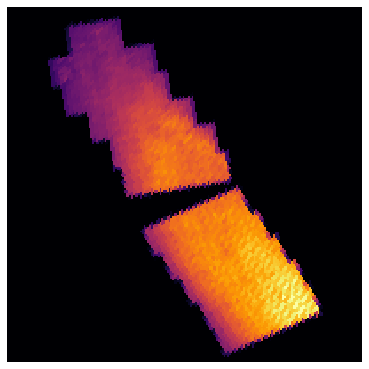

In [16]:
hp.gnomview(hmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1e3,max=8e4)

<a class="anchor" id="depth"></a>
# Make depth and color maps
Now we'll get a little fancier with our maps.  We'll have the database return average WFC3 u-band and ACS magnitudes and colors and the PHAT brick numbers, and make some cuts on the magnitudes and flags of the objects.  We again GROUP BY the nest4096 column.


In [17]:
query = """SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb,
            avg(f475w_vega) as gmag,avg(f814w_vega) as imag,avg(brick) as brick,
            avg(f475w_vega-f814w_vega) as g_i
           FROM phat_v2.phot_mod
           WHERE f475w_gst=1 AND f814w_gst=1 AND f475w_vega<50 AND f814w_vega<50
           GROUP BY nest4096
          """
print(query)

SELECT avg(ra) as ra0,avg(dec) as dec0,nest4096,count(nest4096) as nb,
            avg(f475w_vega) as gmag,avg(f814w_vega) as imag,avg(brick) as brick,
            avg(f475w_vega-f814w_vega) as g_i
           FROM phat_v2.phot_mod
           WHERE f475w_gst=1 AND f814w_gst=1 AND f475w_vega<50 AND f814w_vega<50
           GROUP BY nest4096
          


In [18]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [19]:
df_all = convert(result,'pandas')
print("Number of rows:", len(df_all))
print(np.sum(df_all['nb'])) # print total counts

Number of rows: 2451
75724126


In [20]:
print(df_all.head())

         ra0       dec0  nest4096    nb       gmag       imag  brick       g_i
0  10.987299  41.109672  10746303  2509  26.833515  25.427985    2.0  1.405530
1  11.052603  41.087098  10746315   205  26.658239  25.286244    2.0  1.371995
2  11.060168  41.092374  10746318  5514  26.775284  25.348753    2.0  1.426531
3  11.069515  41.105006  10746319  3633  26.919639  25.499834    2.0  1.419805
4  11.077266  41.115689  10746330   785  27.006906  25.637276    2.0  1.369629


### Healpix map of average F475W magnitude
The map of the average F475W magnitude gives a good idea of how the PHAT catalog depth varies with position in M31.  The depth is much shallower in the Bulge, which is very crowded, than in the outer disk.

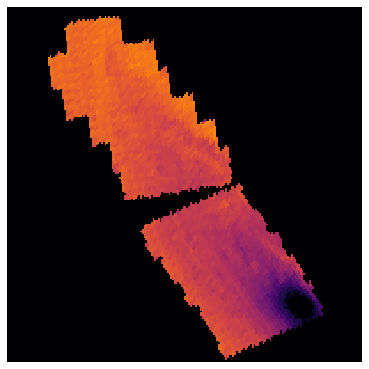

In [21]:
gmap = np.zeros(hp.nside2npix(4096))
gmap[df_all['nest4096']] = df_all['gmag']
hp.gnomview(gmap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=25,max=28)

### Healpix map of average F475W-F814W color
The map of average color reveals both population differences and the dust lanes in the galaxy, as well as the 10 kpc ring.

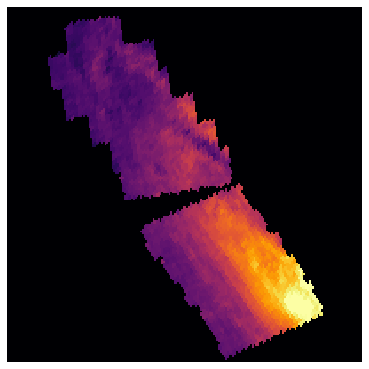

In [22]:
gimap = np.zeros(hp.nside2npix(4096))
gimap[df_all['nest4096']] = df_all['g_i']
hp.gnomview(gimap,title='',notext=True,cbar=False,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='inferno',min=1,max=2.5)

### Healpix map of the brick number
We can also use our Healpix table to make a map of the PHAT bricks.

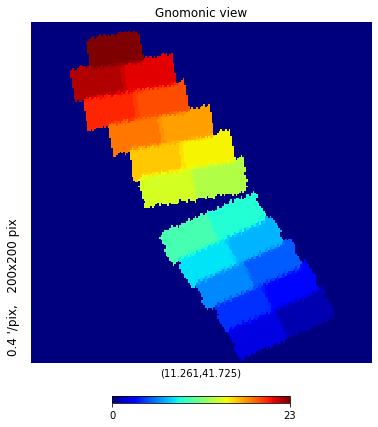

In [23]:
brickmap = np.zeros(hp.nside2npix(4096))
brickmap[df_all['nest4096']] = df_all['brick']
hp.gnomview(brickmap,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='jet',min=0,max=23)

<a class="anchor" id="cmd"></a>
# Do a spatial query and make color-color diagrams and CMDs
Now let's do a cone search for objects within a radius of a particular position.  The PHAT tables are spatially indexed to make such queries fast.  We'll search within a 1 arcmin radius of the RA and Dec position that we defined earlier.

In [24]:
query = """SELECT *
           FROM phat_v2.phot_mod WHERE q3c_radial_query(ra,dec,{0},{1},{2})
        """.format(rarot,decrot,1./60)
print(query)

SELECT *
           FROM phat_v2.phot_mod WHERE q3c_radial_query(ra,dec,11.26091883353094,41.725023988021306,0.016666666666666666)
        


In [25]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

### Cut out bad missing values
Some of the objects returned will have missing magnitude measurements, indicated by 99's.  Let's cut those out, and also select only the "good" stars in the ACS bands.

In [26]:
df = convert(result,'pandas')
print("Number of rows:", len(df))
df_cmd = df[(df['f336w_vega']<50) & (df['f475w_vega']<50) & (df['f814w_vega']<50) & \
          (df['f475w_gst']==1) & (df['f814w_gst']==1)]
print("Number of rows:", len(df_cmd))


Number of rows: 205131
Number of rows: 82060


### Make color-color and CMD plots
We'll show the F475W-F814W,F336W-F475W color-color diagram, and a color-magnitude diagram.  What do you notice?

(28.4, 22.0)

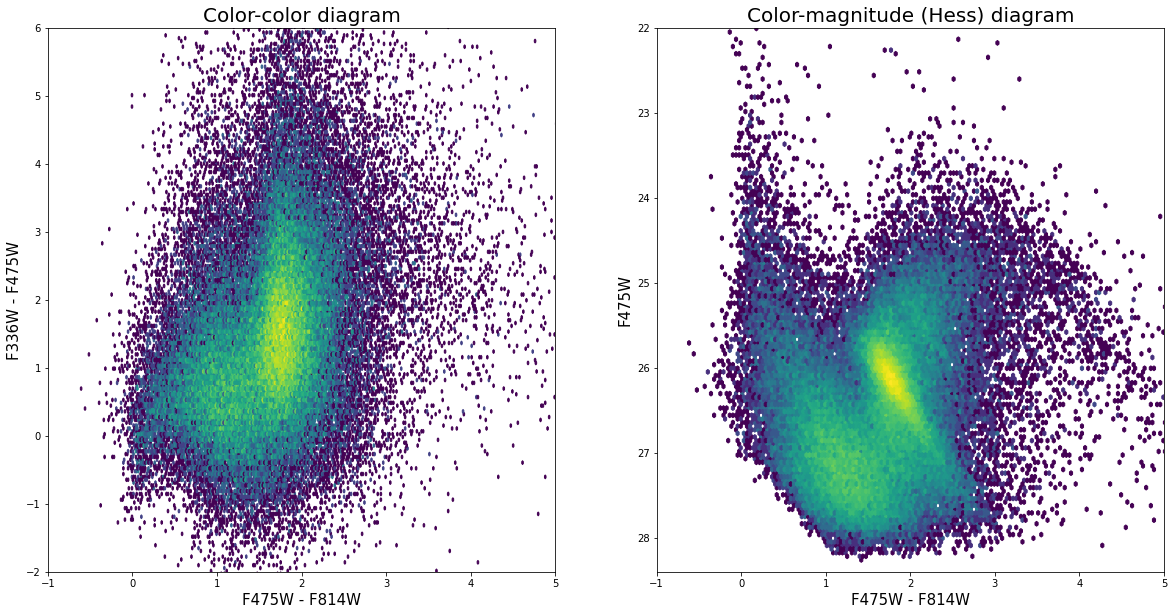

In [27]:
# make a figure
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# color-magnitude diagram (Hess diagram)
im = ax1.hexbin(df_cmd['f475w_vega']-df_cmd['f814w_vega'],df_cmd['f336w_vega']-df_cmd['f475w_vega'], \
                gridsize=400,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax1.set_ylabel('F336W - F475W',fontsize=15)
ax1.set_xlabel('F475W - F814W',fontsize=15)
ax1.set_title('Color-color diagram',fontsize=20)
ax1.set_ylim(-2,6)
ax1.set_xlim(-1,5)


# color-magnitude diagram (Hess diagram)
im2 = ax2.hexbin(df_cmd['f475w_vega']-df_cmd['f814w_vega'],df_cmd['f475w_vega'], \
                 gridsize=200,cmap=matplotlib.cm.viridis,norm=matplotlib.colors.LogNorm())
ax2.set_xlabel('F475W - F814W',fontsize=15)
ax2.set_ylabel('F475W',fontsize=15)
ax2.set_title('Color-magnitude (Hess) diagram',fontsize=20)
ax2.set_xlim(-1,5)
ax2.set_ylim(28.4,22)

<a class="anchor" id="timeseries"></a>
# Retrieving time series photometry of select objects
In this part of the notebook, we'll pick a Cepheid variable, and then query the full measurement table for the time series photometry.  We'll define a couple of functions to retrieve data and make a plot.

In [28]:
# define a function to select only measurements in one band
def get_data(df,band='F475W'):
    sel = (df['filter'] == band) & (df['magvega'] < 90)    
    t = df['mjd'][sel].values
    y = df['magvega'][sel].values
    dy = df['magerr'][sel].values
    return t,y,dy # return time, magnitudes in one band, uncertainties

In [29]:
# a reusable function to plot the lightcurve
def plot_raw_lightcurve(t,y,dy,title='',ax=None,lperc=13,rperc=99,color='g',ms=8):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    jd0 = t.min() # modified Julian date offset
    t = t-jd0 # first date of observations = 0

    ax.errorbar(t,y,yerr=dy,marker='.',ms=ms,ls='none',color=color,lw=1,alpha=0.5,label='')

    # Main panel chores
    ax.set_xlabel('modified Julian date - %g (days)' % jd0, fontsize=20)
    ax.set_ylabel('magnitude',fontsize=20)
    ax.tick_params(labelsize=20)
    ax.invert_yaxis()
    ax.set_title(title)


In [30]:
def get_folded_phase(t,best_period):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period) % 1
    
    return phase

In [31]:
def plot_folded_lightcurve(t,y,best_period,dy=None,ax=None,color='g',ms=10):
    
    """Plot folded lightcurve.
    
    Parameters
    ----------
    
    t, y : array
        Time and magnitude 1-d arrays
        
    best_period : float
        True period of the signal.
        
    dy : array or None
        If array, the values are the uncertainies on ``y``, and the plot will show errorbars.
        If None, the plot will have no errorbars.
        
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """

    phase = get_folded_phase(t,best_period)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    marker = '.'
    lw = 1
    alpha = 0.6
    
    
    if dy is not None:
        ax.errorbar(phase,y,yerr=dy,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
    else:
        ax.plot(phase,y,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
            
    ax.invert_yaxis()
    ax.tick_params(labelsize=20)
    ax.set_xlabel('phase (days)', fontsize=20)
    ax.set_ylabel('magnitude',fontsize=20);

In [32]:
# Pick a star from Wagner-Kaiser et al. (2015)
rawk = 11.02203
decwk = 41.23451
best_period = 10.29 # days
query = """SELECT * FROM phat_v2.phot_meas WHERE q3c_radial_query(ra,dec,{0},{1},{2})""".format(rawk,decwk,0.2/3600)
print(query)

SELECT * FROM phat_v2.phot_meas WHERE q3c_radial_query(ra,dec,11.02203,41.23451,5.555555555555556e-05)


In [33]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [34]:
df_ts = convert(result,'pandas')
print("Number of rows:", len(df_ts))
print(df_ts['filter'].unique())
print(df_ts['objid'].unique())


Number of rows: 62
['F336W' 'F814W' 'F475W' 'F275W' 'F160W' 'F110W']
['PHAT_11.0220304+41.234515']


In [35]:
uid=df_ts['objid'].unique()
df_ts=df_ts[(df_ts['objid']==uid[0])]

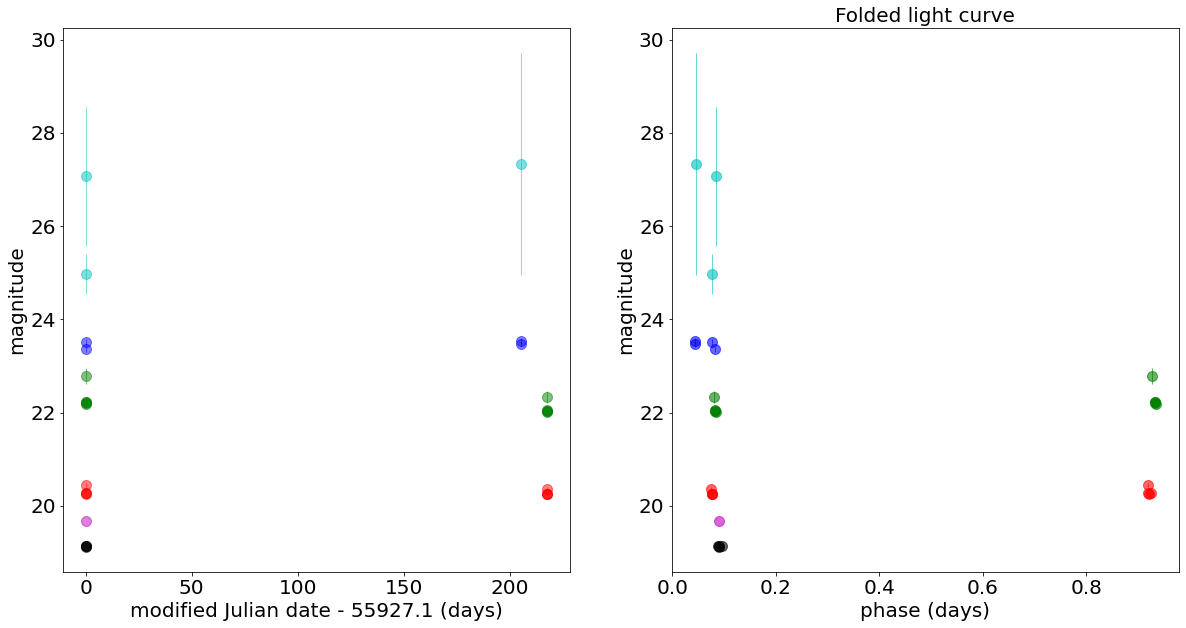

In [36]:
colors = list('gcbrkm')
filters = ['F475W','F275W','F336W','F814W','F160W','F110W']
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax2.set_title('Folded light curve',fontsize=20)
for j in range(len(colors)):
   c = colors[j]
   t,y,dy = get_data(df_ts,filters[j])
   plot_raw_lightcurve(t,y,dy,title='',ax=ax1,color=c,ms=20)
   plot_folded_lightcurve(t,y,best_period,dy=dy,ax=ax2,color=c,ms=20)


<a class="anchor" id="resources"></a>
# Resources and references
Dalcanton, J.J. et al. (2012, ApJS, 200, 18), "The Panchromatic Hubble Andromeda Treasury"
http://adsabs.harvard.edu/abs/2012ApJS..200...18D

Wagner-Kaiser, R. et al. (2015, MNRAS, 451, 724), "Panchromatic Hubble Andromeda Treasury XIII: The Cepheid period-luminosity relation in M31"
http://adsabs.harvard.edu/abs/2015MNRAS.451..724W

Williams, B.F. et al. (2014, ApJS, 215, 9), "The Panchromatic Hubble Andromeda Treasury. X. Ultraviolet to Infrared Photometry of 117 Million Equidistant Stars"
http://adsabs.harvard.edu/abs/2014ApJS..215....9W

Williams, B.F. et al., "Reducing and Analyzing the PHAT Survey with the Cloud", ApJS, 236, 4 https://ui.adsabs.harvard.edu/abs/2018ApJS..236....4W
